In [1]:
import pickle
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import scale

#from keras.models import Sequential
#from keras.optimizers import SGD, Adam, Adagrad
#from keras import backend as K
#from keras.layers import Embedding
#from keras.layers import Dense, Reshape, Concatenate, Activation, Dropout
#from keras.callbacks import ModelCheckpoint

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_cache = 'cache/train.pickle'
train_labels_cache = 'cache/train-labels.npy'
validation_cache = 'cache/validation.pickle'
validation_labels_cache = 'cache/validation-labels.npy'
test_cache = 'cache/test.pickle'
test_labels_cache = 'cache/test-labels.npy'
competition_test_cache = 'cache/competition-test.pickle'
metadata_cache = 'cache/metadata.pickle'

In [3]:
train_cache = 'cache/train2.pickle'
train_labels_cache = 'cache/train-labels2.npy'
validation_cache = 'cache/validation2.pickle'
validation_labels_cache = 'cache/validation-labels2.npy'
test_cache = 'cache/test2.pickle'
test_labels_cache = 'cache/test-labels2.npy'
competition_test_cache = 'cache/competition-test2.pickle'
metadata_cache = 'cache/metadata2.pickle'

In [4]:
train = pd.read_pickle(train_cache)
validation = pd.read_pickle(validation_cache)
test = pd.read_pickle(test_cache)

train_labels = np.load(train_labels_cache)
validation_labels = np.load(validation_labels_cache)
test_labels = np.load(test_labels_cache)

competition_test = pd.read_pickle(competition_test_cache)
with open(metadata_cache, 'rb') as handle:
    metadata = pickle.load(handle)

In [8]:
def process_features(df):
    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED','ORIGIN_STAND_ENCODED',
                           'dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
                           'dt_2014-12-21 00:00:00']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_CALL_ENCODED','TAXI_ID_ENCODED',
#                            'ORIGIN_STAND_ENCODED']].values)
#def process_features(df):
#    return torch.tensor(df[['QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','ORIGIN_STAND_ENCODED','dt_2014-08-14 00:00:00','dt_2014-09-30 00:00:00','dt_2014-10-06 00:00:00','dt_2014-11-01 00:00:00',
#                           'dt_2014-12-21 00:00:00']].values)

In [9]:
#Two layers got 726
#Three layers also 726
#200 epochs for >=300, three layers 708: 65, 100, 40, 10, 1
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.embed_quarter_hour = nn.Embedding(metadata['n_quarter_hours'], 10)
        self.embed_day_of_week = nn.Embedding(metadata['n_days_per_week'], 10)
        self.embed_week_of_year = nn.Embedding(metadata['n_weeks_per_year'],10)
        self.embed_client_ids = nn.Embedding(metadata['n_client_ids'],10)
        self.embed_taxi_ids = nn.Embedding(metadata['n_taxi_ids'],10)
        self.embed_stand_ids = nn.Embedding(metadata['n_stand_ids'],10)
        self.layer1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=65, out_features=100),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features = 100, out_features = 40),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features = 40, out_features = 10),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        qhr = self.embed_quarter_hour(x[:,0].to(torch.int32))
        dow = self.embed_day_of_week(x[:,1].to(torch.int32))
        woy = self.embed_week_of_year(x[:,2].to(torch.int32))
        ci = self.embed_client_ids(x[:,3].to(torch.int32))
        ti = self.embed_taxi_ids(x[:,4].to(torch.int32))
        si =  self.embed_stand_ids(x[:,5].to(torch.int32))
        x = torch.cat([qhr,dow,woy,ci,ti,si,x[:,6:]],axis=1)
        x = x.to(torch.float32)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

In [10]:
import torch.optim as optim
learning_rate = 0.0001
criterion = nn.MSELoss()
num_epochs = 200

In [11]:
x=process_features(train)
x.shape

torch.Size([300342, 11])

In [12]:
train_data = process_features(train)
train_data = TensorDataset(train_data, torch.tensor(train_labels))
validate_data = process_features(validation)
validate_data = TensorDataset(validate_data,torch.tensor(validation_labels))
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validate_data, batch_size = BATCH_SIZE,shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
all_losses = []
train_loss = []

In [13]:
model = MLP()
model = model.to(device)

In [15]:
def validate(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Reshape targets
            targets = torch.reshape(targets,(-1,1))

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = torch.sqrt(criterion(outputs, targets))  # RMSE

            # Accumulate loss
            running_val_loss += loss.item()

    # Return average loss
    average_val_loss = running_val_loss / len(val_loader)
    return average_val_loss


In [16]:
def train_data(model, train_loader, val_loader, criterion, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    for epoch in range(num_epochs):
        # Training Phase 
        model.train()
        epoch_loss = 0
        for i,(x, y) in enumerate(train_loader,0):
            x = x.to(device)
            y = y.to(device).to(torch.float32)
            y = torch.reshape(y,(-1,1))
            optimizer.zero_grad()
            output = model(x)
            loss = torch.sqrt(criterion(output, y))#RMSE
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        all_losses.append(epoch_loss/len(train_loader))
        print(f"Epoch: {epoch} Training Loss:{epoch_loss/len(train_loader)}")

        # Validation Phase
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = torch.reshape(y_val,(-1,1))
                preds = model(x_val)
                val_loss += torch.sqrt(criterion(preds, y_val)).item() # RMSE
        print(f"Epoch: {epoch} Validation Loss:{val_loss/len(val_loader)}")
        PATH = f'model_state/model_epoch{epoch}_greater300.pth'     
        torch.save(model.state_dict(), PATH)

In [17]:
train_data(model, train_loader, val_loader, criterion, 200) # use the training function you defined
val_loss = validate(model, val_loader, criterion)

Epoch: 0 Training Loss:841.0045114134442
Epoch: 0 Validation Loss:616.4064025878906
Epoch: 1 Training Loss:700.5171216095972
Epoch: 1 Validation Loss:611.7191963195801
Epoch: 2 Training Loss:692.0592989830144
Epoch: 2 Validation Loss:605.0415369669596
Epoch: 3 Training Loss:686.7024087016005
Epoch: 3 Validation Loss:600.1835568745931
Epoch: 4 Training Loss:682.3868691924282
Epoch: 4 Validation Loss:591.405642191569
Epoch: 5 Training Loss:677.6768150508378
Epoch: 5 Validation Loss:595.6292152404785
Epoch: 6 Training Loss:676.5095269455521
Epoch: 6 Validation Loss:597.2507235209147
Epoch: 7 Training Loss:672.3801766888456
Epoch: 7 Validation Loss:596.9218813578287
Epoch: 8 Training Loss:670.4242292224574
Epoch: 8 Validation Loss:597.2151196797689
Epoch: 9 Training Loss:668.4452725553898
Epoch: 9 Validation Loss:592.7480430603027
Epoch: 10 Training Loss:664.9556677110864
Epoch: 10 Validation Loss:591.9407869974772
Epoch: 11 Training Loss:664.2761144520224
Epoch: 11 Validation Loss:595.713

Epoch: 96 Training Loss:613.4449508660491
Epoch: 96 Validation Loss:539.8410161336263
Epoch: 97 Training Loss:615.0054197372352
Epoch: 97 Validation Loss:556.5896517435709
Epoch: 98 Training Loss:613.0085537507781
Epoch: 98 Validation Loss:552.3721987406412
Epoch: 99 Training Loss:614.1523413574843
Epoch: 99 Validation Loss:556.7738711039225
Epoch: 100 Training Loss:612.9898116538816
Epoch: 100 Validation Loss:555.1332372029623
Epoch: 101 Training Loss:612.2317276813652
Epoch: 101 Validation Loss:553.2395985921224
Epoch: 102 Training Loss:612.7527664243083
Epoch: 102 Validation Loss:554.3772176106771
Epoch: 103 Training Loss:612.3197752762003
Epoch: 103 Validation Loss:548.3533490498861
Epoch: 104 Training Loss:612.2446532084884
Epoch: 104 Validation Loss:548.7890243530273
Epoch: 105 Training Loss:611.3141256624148
Epoch: 105 Validation Loss:556.8169746398926
Epoch: 106 Training Loss:610.1551466601729
Epoch: 106 Validation Loss:542.9798164367676
Epoch: 107 Training Loss:611.44056589185

Epoch: 190 Training Loss:589.8311547180618
Epoch: 190 Validation Loss:543.8695742289225
Epoch: 191 Training Loss:590.155090748121
Epoch: 191 Validation Loss:538.5910326639811
Epoch: 192 Training Loss:589.0018894632776
Epoch: 192 Validation Loss:546.5096842447916
Epoch: 193 Training Loss:590.2908757018392
Epoch: 193 Validation Loss:541.3605893452963
Epoch: 194 Training Loss:588.6300548395808
Epoch: 194 Validation Loss:548.1190172831217
Epoch: 195 Training Loss:589.0216808343472
Epoch: 195 Validation Loss:549.4635162353516
Epoch: 196 Training Loss:587.9160464936538
Epoch: 196 Validation Loss:540.5335528055826
Epoch: 197 Training Loss:588.1796015384708
Epoch: 197 Validation Loss:549.0305836995443
Epoch: 198 Training Loss:587.557688325834
Epoch: 198 Validation Loss:548.5306243896484
Epoch: 199 Training Loss:588.4573068314021
Epoch: 199 Validation Loss:553.3724517822266


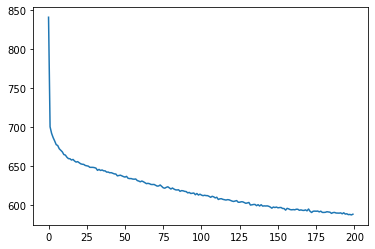

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(all_losses)))

In [19]:
def view_loss(model, test_set, test_label,criterion):
    total_loss=0
    test_dataset = TensorDataset(test_set, test_label)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y = torch.reshape(y,(-1,1))
        output = model(x)
        loss = torch.sqrt(criterion(output, y))#RMSE
        total_loss += loss
    return total_loss

In [20]:
test_losses = []
for i in range(200):
    model.load_state_dict(torch.load(f'model_state/model_epoch{i}_greater300.pth'))
    test_losses.append(view_loss(model,process_features(test),torch.tensor(test_labels).to(torch.float32),criterion)/process_features(test).shape[0]*128)
    print(f"epoch: {i}, test loss: {view_loss(model, process_features(test), torch.tensor(test_labels).to(torch.float32), criterion)/process_features(test).shape[0]*128}")

epoch: 0, test loss: 656.8514404296875
epoch: 1, test loss: 652.489501953125
epoch: 2, test loss: 656.1748046875
epoch: 3, test loss: 648.8671264648438
epoch: 4, test loss: 643.8526611328125
epoch: 5, test loss: 649.3121337890625
epoch: 6, test loss: 644.5361938476562
epoch: 7, test loss: 637.3853759765625
epoch: 8, test loss: 641.1902465820312
epoch: 9, test loss: 634.7704467773438
epoch: 10, test loss: 630.18310546875
epoch: 11, test loss: 635.7705078125
epoch: 12, test loss: 630.619873046875
epoch: 13, test loss: 637.5054321289062
epoch: 14, test loss: 638.4015502929688
epoch: 15, test loss: 636.194091796875
epoch: 16, test loss: 634.5285034179688
epoch: 17, test loss: 634.40576171875
epoch: 18, test loss: 638.10595703125
epoch: 19, test loss: 632.1621704101562
epoch: 20, test loss: 635.1085815429688
epoch: 21, test loss: 640.7289428710938
epoch: 22, test loss: 632.3276977539062
epoch: 23, test loss: 634.2333374023438
epoch: 24, test loss: 634.9292602539062
epoch: 25, test loss: 623

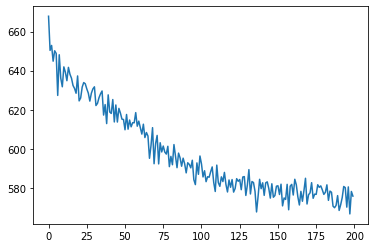

In [21]:
plt.figure()
plt.plot(torch.Tensor.cpu(torch.tensor(test_losses)))

In [35]:
model.load_state_dict(torch.load('model_state/model_epoch199_greater300.pth'))

<All keys matched successfully>

In [36]:
predict_input = torch.tensor(process_features(competition_test)).to(device)
print(predict_input.shape)

torch.Size([320, 11])


/tmp/ipykernel_3678/1078090879.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predict_input = torch.tensor(process_features(competition_test)).to(device)


In [37]:
def predict(model):
    predict_output = model(predict_input)
    return predict_output

In [38]:
out = predict(model)

In [39]:
embed_mlp_predict = pd.read_csv('test_public.csv')
embed_mlp_predict = embed_mlp_predict['TRIP_ID']
predict_tensor = out.to('cpu').detach().numpy().flatten()
embed_mlp_predict= pd.concat([embed_mlp_predict, pd.DataFrame(predict_tensor)], axis=1)
embed_mlp_predict = embed_mlp_predict.rename(columns={0: 'TRAVEL_TIME'})
embed_mlp_predict[0:50]

,TRIP_ID,TRAVEL_TIME
0,T1,792.238525
1,T2,671.317749
2,T3,740.217896
3,T4,673.028931
4,T5,673.787048
5,T6,673.935425
6,T7,746.509460
7,T8,823.881653
8,T9,684.157410
9,T10,746.034241


In [40]:
embed_mlp_predict['TRAVEL_TIME'].mean()

874.71875

In [41]:
embed_mlp_predict.to_csv('Embedding_MLP_199_greater300.csv', index=False)

In [ ]:
a = process_features(train)
print(a[:,0])
embedding1 = torch.nn.Embedding(96, 10)
embedding2 = torch.nn.Embedding()
print(embedding(a[0,0].to(torch.int32)))